# Little Sister
*Mohamed et Orkaëlle*

La société "Little Sister" est une entreprise spécialisée dans le secteur de la vidéosurveillance. Pour leur prochain produit, elle souhaite développer un algorithme d'intelligence artificielle afin de détecter les différents éléments présents sur une image. Elle vous sollicite afin de l'aider à réaliser le système.

In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import fct_utiles as fct

## 0 - Initialisation

In [152]:
# Téléchargement et décompression des données
fct.ensure_data_loaded()

Datas already downloaded.
Datas are successfully loaded.



In [153]:
# Choix des thèmes
objets = ['butterfly','crocodile','rocket']
fct.copy_data(objets)

Echantillon copié dans dossier CURATED.


## 1 - Préparation des données

In [154]:
modelName = 'model001'

In [155]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [156]:
tf.random.set_seed(2)

In [172]:
# Préparation des données
trainPath = './DATAS/CURATED/train/'
testPath = './DATAS/CURATED/test/'
IMAGE_SIZE    = (32, 32)
NUM_CLASSES   = len(objets)
BATCH_SIZE    = 64
NUM_EPOCHS    = 10

imageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

train_generator = imageDataGenerator.flow_from_directory(
    directory=trainPath,
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training'
)

test_generator = imageDataGenerator.flow_from_directory(
    directory=testPath,
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

Found 1200 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


## TEST 1 - 1 convolution 3x3

In [290]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model1.add(Flatten())
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
flatten_37 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_108 (Dense)            (None, 3)                 86403     
Total params: 87,299
Trainable params: 87,299
Non-trainable params: 0
_________________________________________________________________


In [291]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model1.fit_generator(train_generator, epochs=NUM_EPOCHS, validation_data=test_generator)

Epoch 1/10
19/19 [==============================] - 1s 54ms/step - loss: 142.8772 - accuracy: 0.5017 - val_loss: 22.3051 - val_accuracy: 0.6167
Epoch 2/10
19/19 [==============================] - 1s 41ms/step - loss: 17.3129 - accuracy: 0.7025 - val_loss: 14.2038 - val_accuracy: 0.7333
Epoch 3/10
19/19 [==============================] - 1s 33ms/step - loss: 8.7017 - accuracy: 0.7442 - val_loss: 9.5303 - val_accuracy: 0.7167
Epoch 4/10
19/19 [==============================] - 1s 33ms/step - loss: 6.5114 - accuracy: 0.7675 - val_loss: 8.4856 - val_accuracy: 0.7167
Epoch 5/10
19/19 [==============================] - 1s 43ms/step - loss: 3.4631 - accuracy: 0.8267 - val_loss: 7.7643 - val_accuracy: 0.7500
Epoch 6/10
19/19 [==============================] - 1s 40ms/step - loss: 1.3196 - accuracy: 0.9067 - val_loss: 5.7748 - val_accuracy: 0.7667
Epoch 7/10
19/19 [==============================] - 1s 35ms/step - loss: 0.7543 - accuracy: 0.9308 - val_loss: 7.2223 - val_accuracy: 0.7333
Epoch 8/

In [292]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

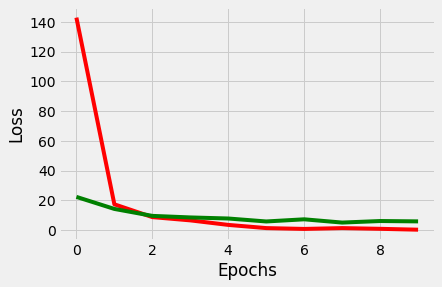

In [293]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

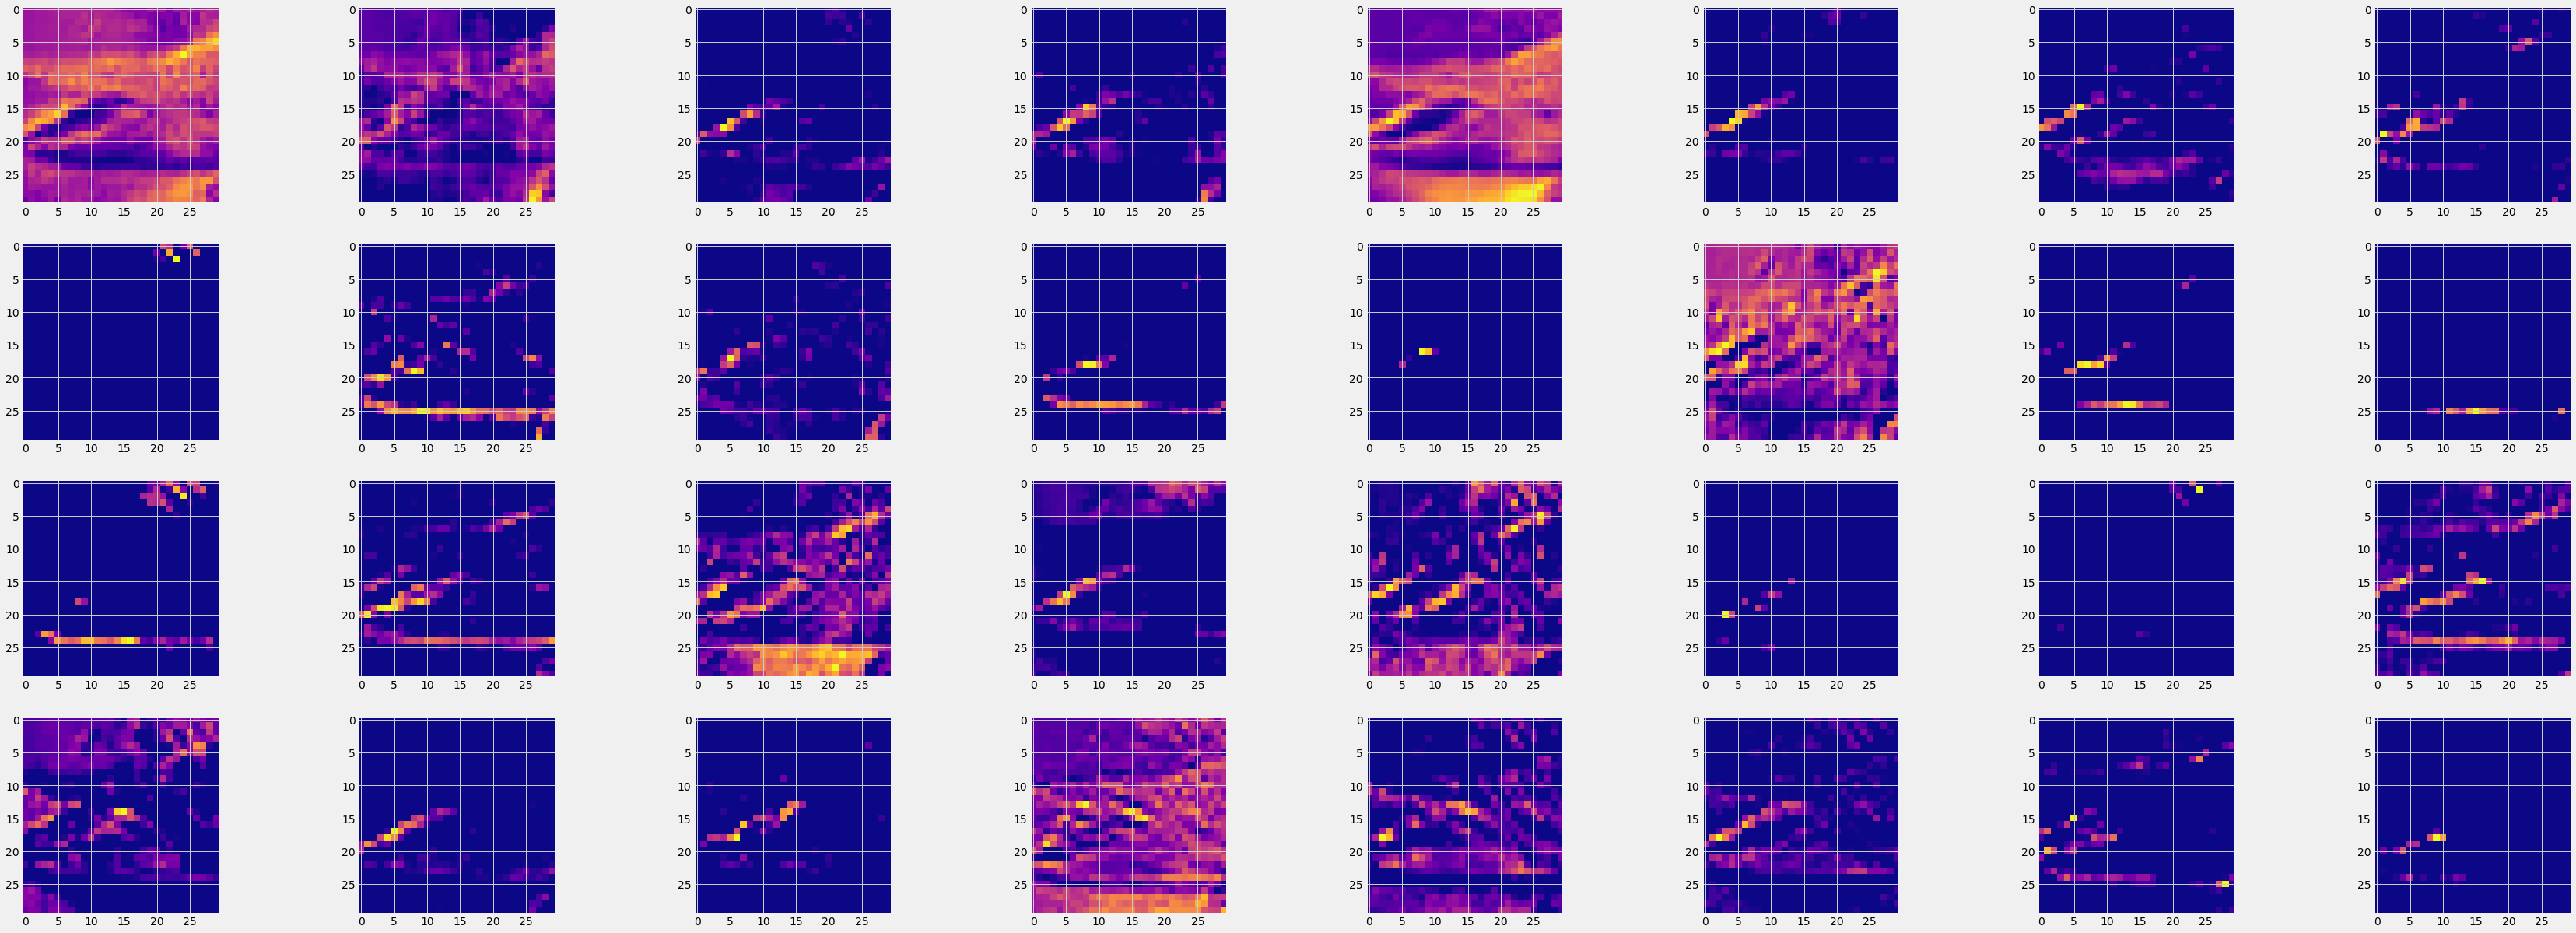

In [294]:
from keras.models import Model
from keras.preprocessing import image
import numpy as np

layer_outputs = [layer.output for layer in model1.layers]

test_image = "./DATAS/CURATED/test/crocodile/0097.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1

display_activation(activations, 8, 4, 0)

**Conclusion :**

On constate que la convolution nous renvoie des outputs interessants, les contours du crocodile sont identifiés.
Voyons ce que fait le MaxPooling à la suite :

## TEST 2 - On rajoute un MaxPooling

In [295]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_109 (Dense)            (None, 3)                 21603     
Total params: 22,499
Trainable params: 22,499
Non-trainable params: 0
_________________________________________________________________


In [296]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model2.fit_generator(train_generator, epochs=NUM_EPOCHS, validation_data=test_generator)

Epoch 1/10
19/19 [==============================] - 1s 59ms/step - loss: 47.6110 - accuracy: 0.4525 - val_loss: 7.9384 - val_accuracy: 0.6000
Epoch 2/10
19/19 [==============================] - 1s 35ms/step - loss: 6.8702 - accuracy: 0.6517 - val_loss: 3.6950 - val_accuracy: 0.6333
Epoch 3/10
19/19 [==============================] - 1s 36ms/step - loss: 2.5870 - accuracy: 0.7208 - val_loss: 2.3852 - val_accuracy: 0.6667
Epoch 4/10
19/19 [==============================] - 1s 36ms/step - loss: 1.4566 - accuracy: 0.7858 - val_loss: 1.7010 - val_accuracy: 0.7500
Epoch 5/10
19/19 [==============================] - 1s 35ms/step - loss: 0.9643 - accuracy: 0.8233 - val_loss: 1.7757 - val_accuracy: 0.7167
Epoch 6/10
19/19 [==============================] - 1s 34ms/step - loss: 0.6978 - accuracy: 0.8500 - val_loss: 1.5639 - val_accuracy: 0.8000
Epoch 7/10
19/19 [==============================] - 1s 43ms/step - loss: 0.4569 - accuracy: 0.8925 - val_loss: 1.6195 - val_accuracy: 0.7667
Epoch 8/10
1

In [297]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

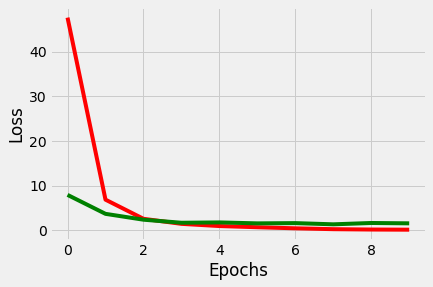

In [298]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [299]:
layer_outputs = [layer.output for layer in model2.layers]

test_image = "./DATAS/CURATED/test/crocodile/0097.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model2.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

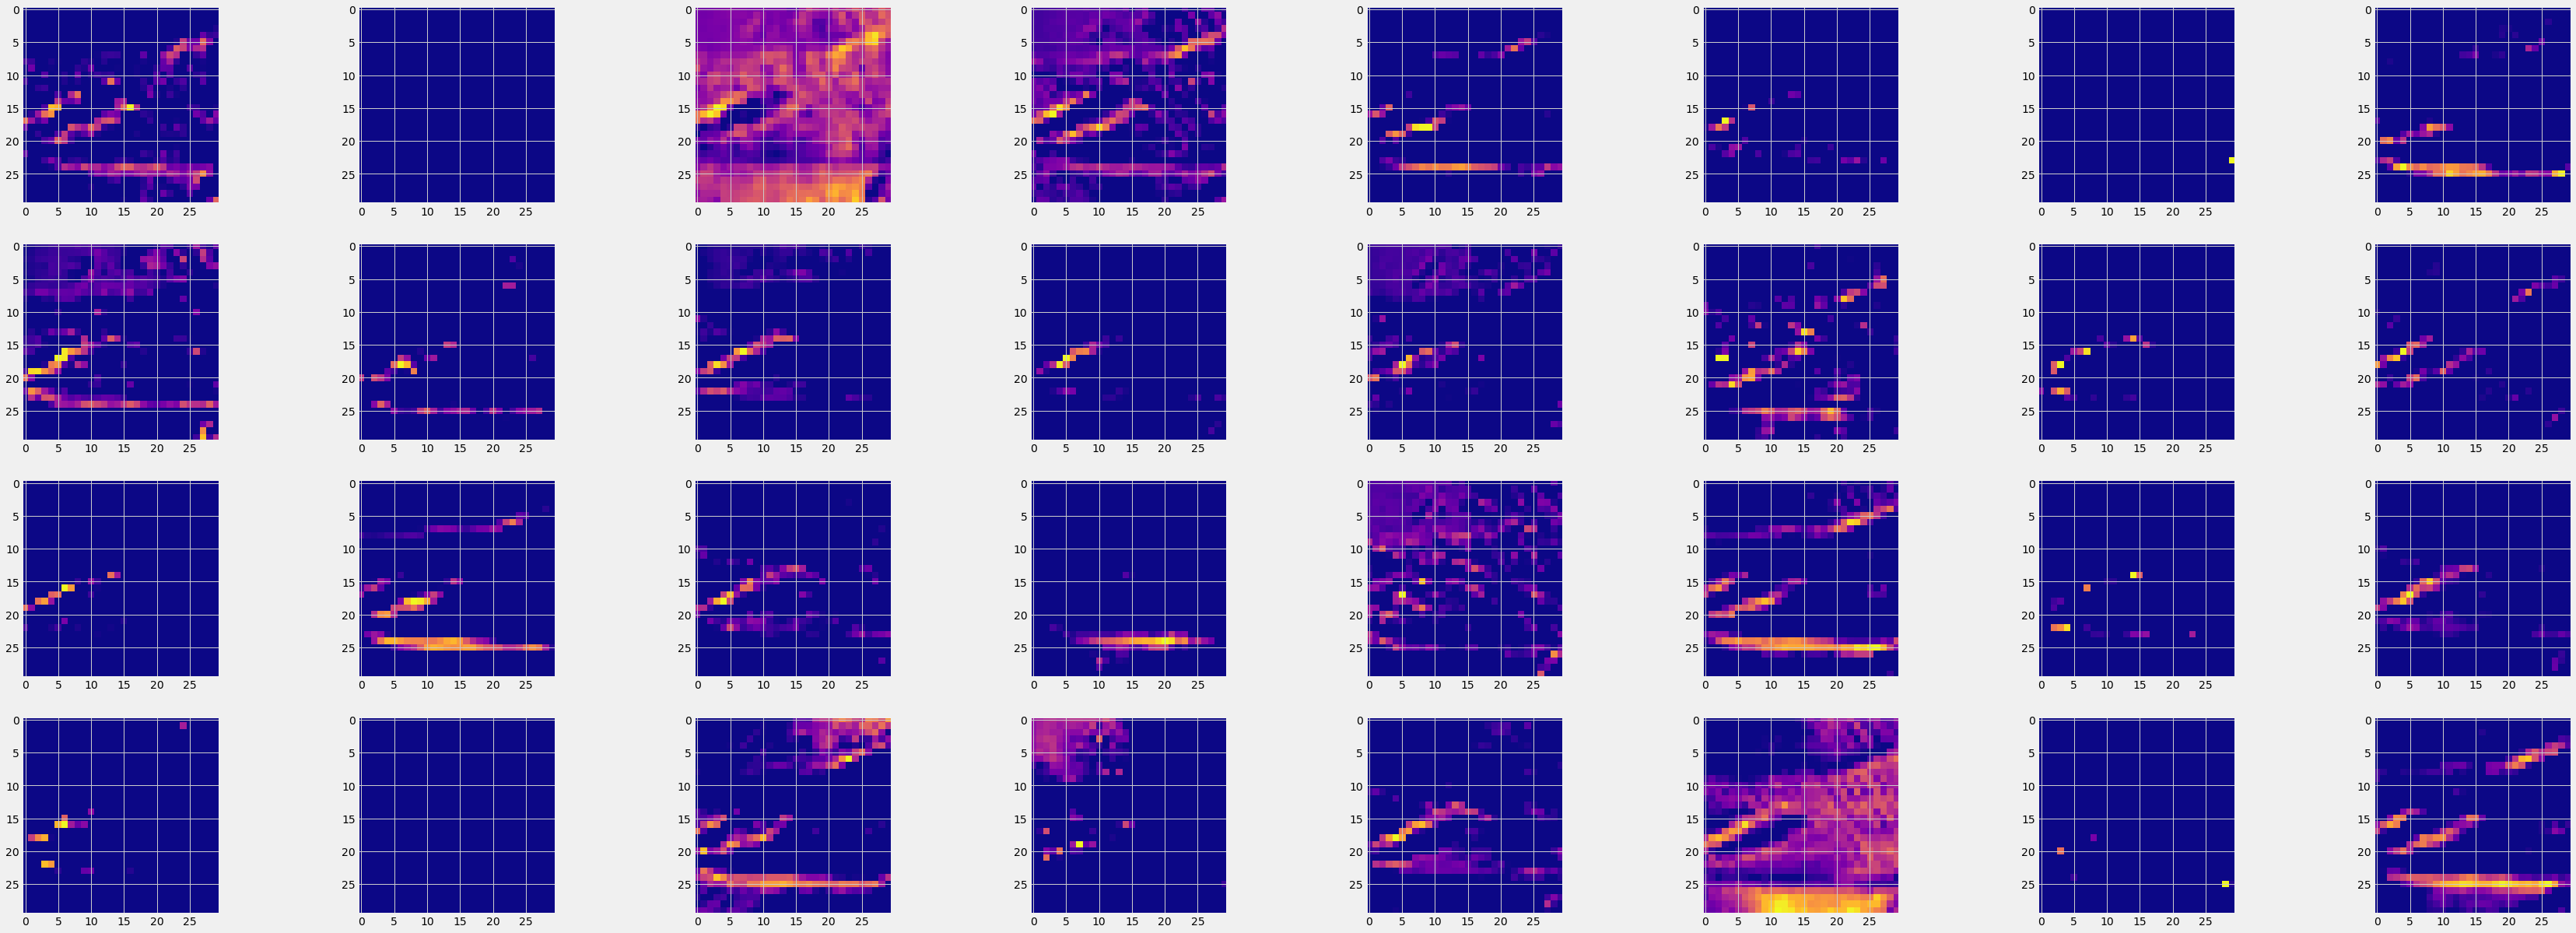

In [300]:
display_activation(activations, 8, 4, 0)

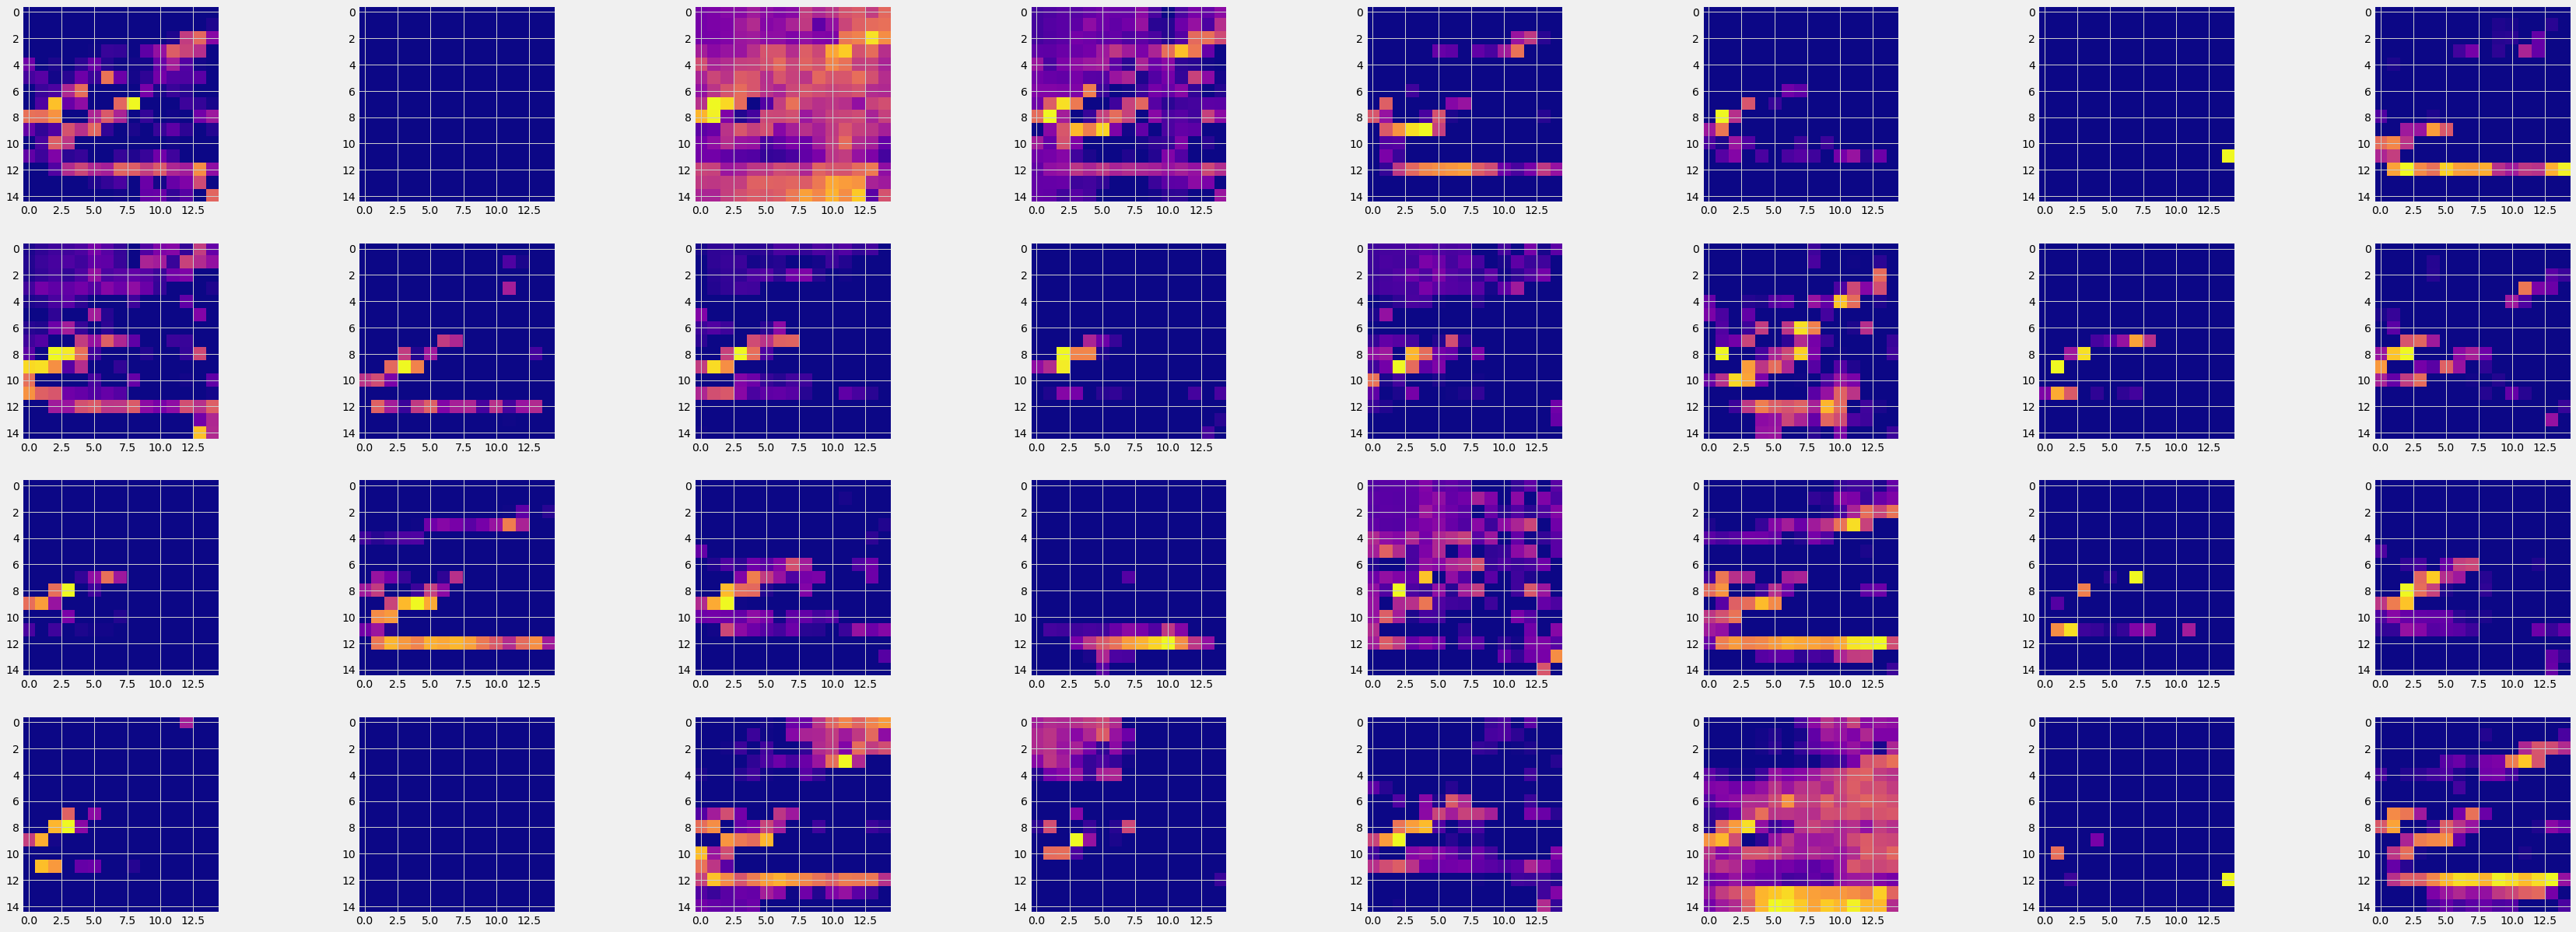

In [301]:
display_activation(activations, 8, 4, 1)

**Conclusion :**

On constate qu'avec l'ajout du Pooling, la convolution nous renvoie des outputs également interessants, les contours du crocodile sont bien définis et identifiés. Essayons de placer une nouvelle convolution / pooling à la suite :

## TEST 3 - On rajoute une Convolution

In [302]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 3)                 6915      
Total params: 26,307
Trainable params: 26,307
Non-trainable params: 0
_________________________________________________

In [303]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model3.fit_generator(train_generator, epochs=NUM_EPOCHS, validation_data=test_generator)

Epoch 1/10
19/19 [==============================] - 1s 79ms/step - loss: 10.8848 - accuracy: 0.4608 - val_loss: 3.3367 - val_accuracy: 0.5500
Epoch 2/10
19/19 [==============================] - 1s 55ms/step - loss: 1.7016 - accuracy: 0.6667 - val_loss: 1.2106 - val_accuracy: 0.7167
Epoch 3/10
19/19 [==============================] - 1s 52ms/step - loss: 0.9204 - accuracy: 0.7300 - val_loss: 1.0089 - val_accuracy: 0.7000
Epoch 4/10
19/19 [==============================] - 1s 57ms/step - loss: 0.6610 - accuracy: 0.7800 - val_loss: 0.8826 - val_accuracy: 0.8167
Epoch 5/10
19/19 [==============================] - 1s 53ms/step - loss: 0.4912 - accuracy: 0.8292 - val_loss: 0.9095 - val_accuracy: 0.7333
Epoch 6/10
19/19 [==============================] - 1s 53ms/step - loss: 0.3836 - accuracy: 0.8708 - val_loss: 0.8043 - val_accuracy: 0.7833
Epoch 7/10
19/19 [==============================] - 1s 52ms/step - loss: 0.3041 - accuracy: 0.8917 - val_loss: 0.8765 - val_accuracy: 0.7667
Epoch 8/10
1

In [304]:
model3.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

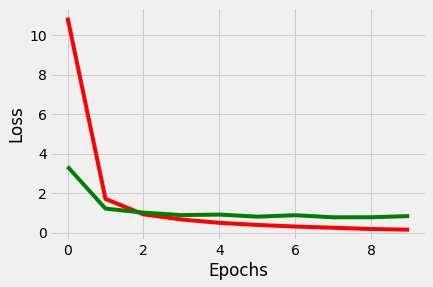

In [305]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [306]:
layer_outputs = [layer.output for layer in model3.layers]

test_image = "./DATAS/CURATED/test/crocodile/0097.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model3.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

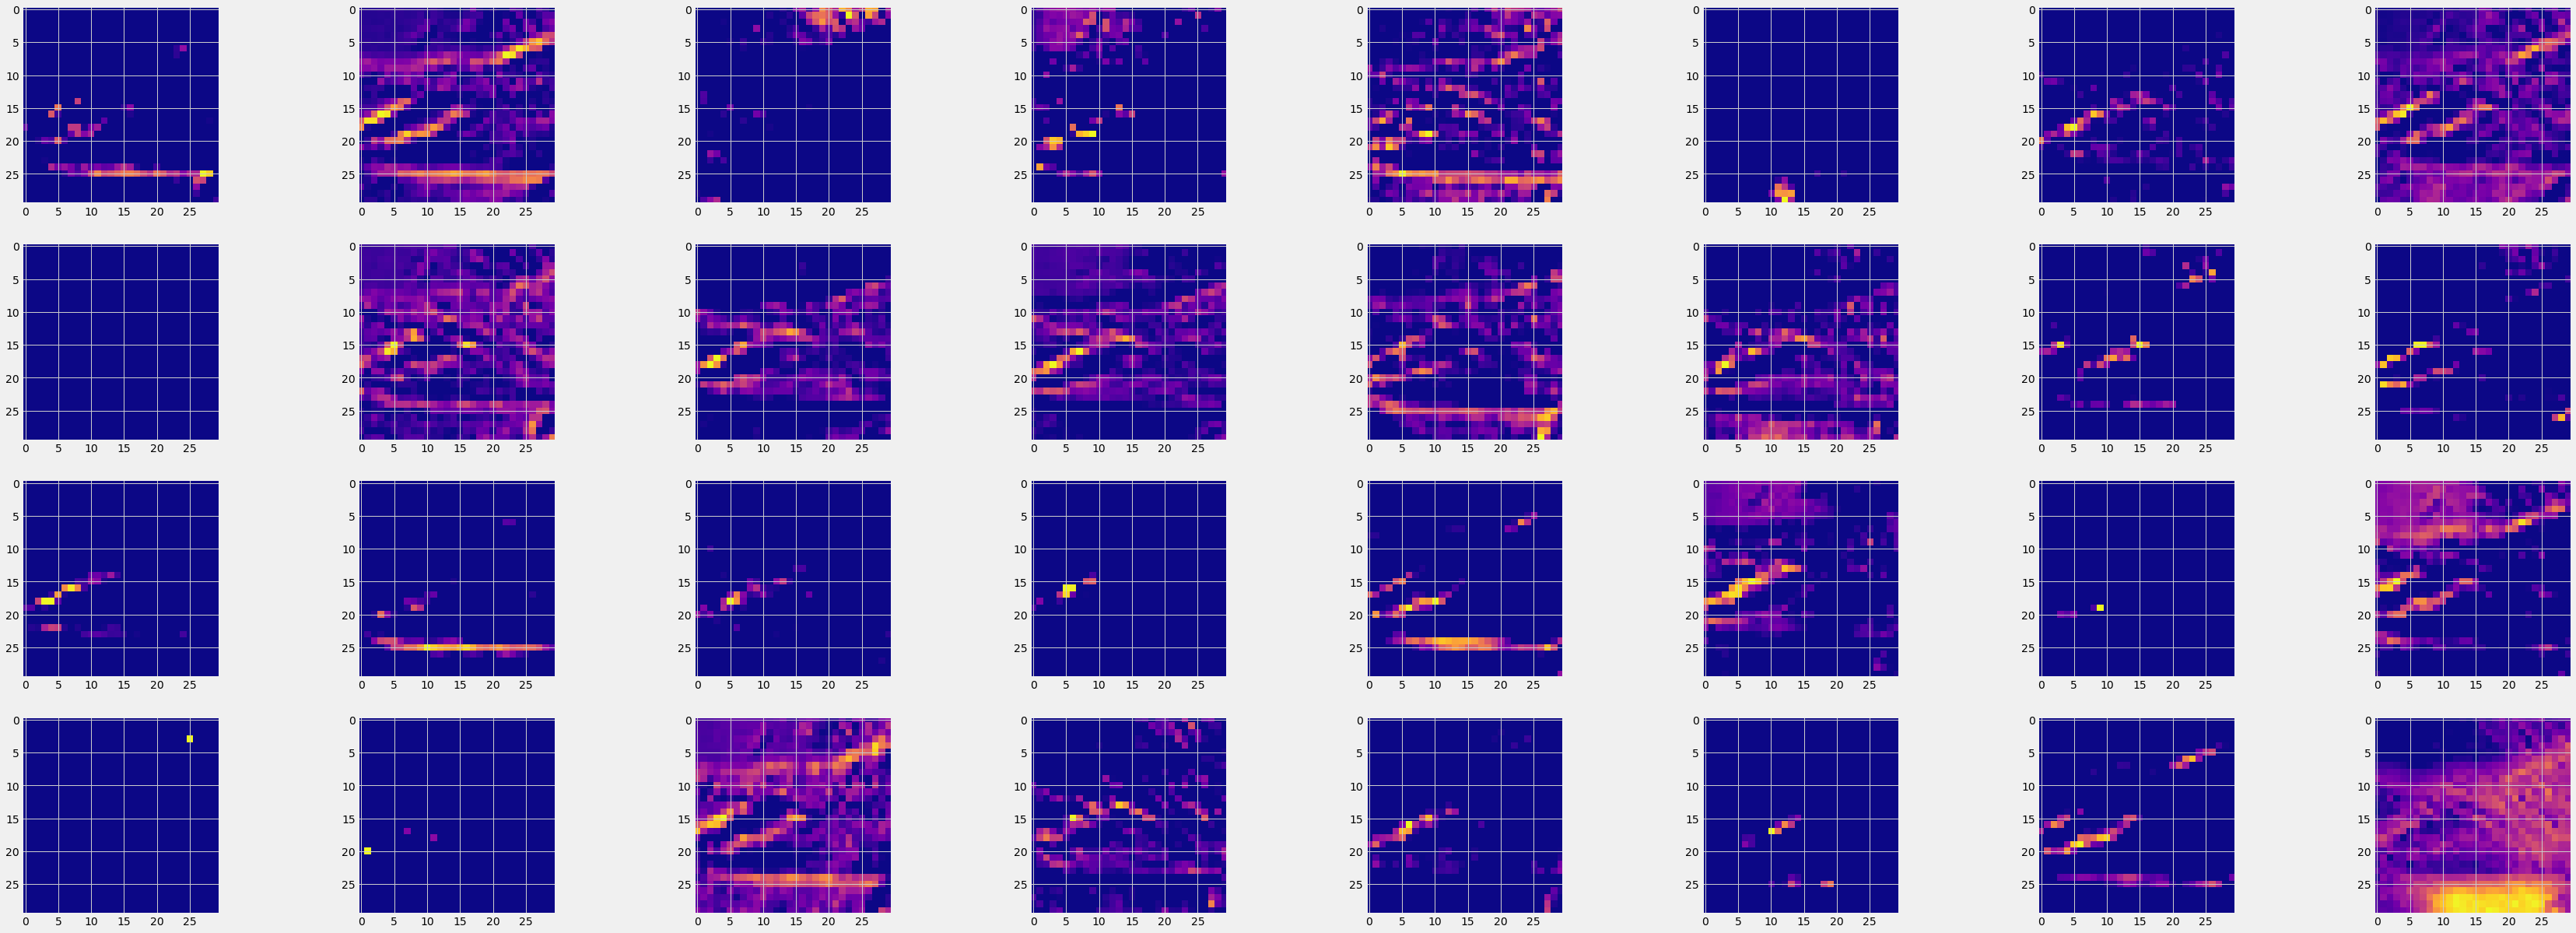

In [307]:
display_activation(activations, 8, 4, 0)

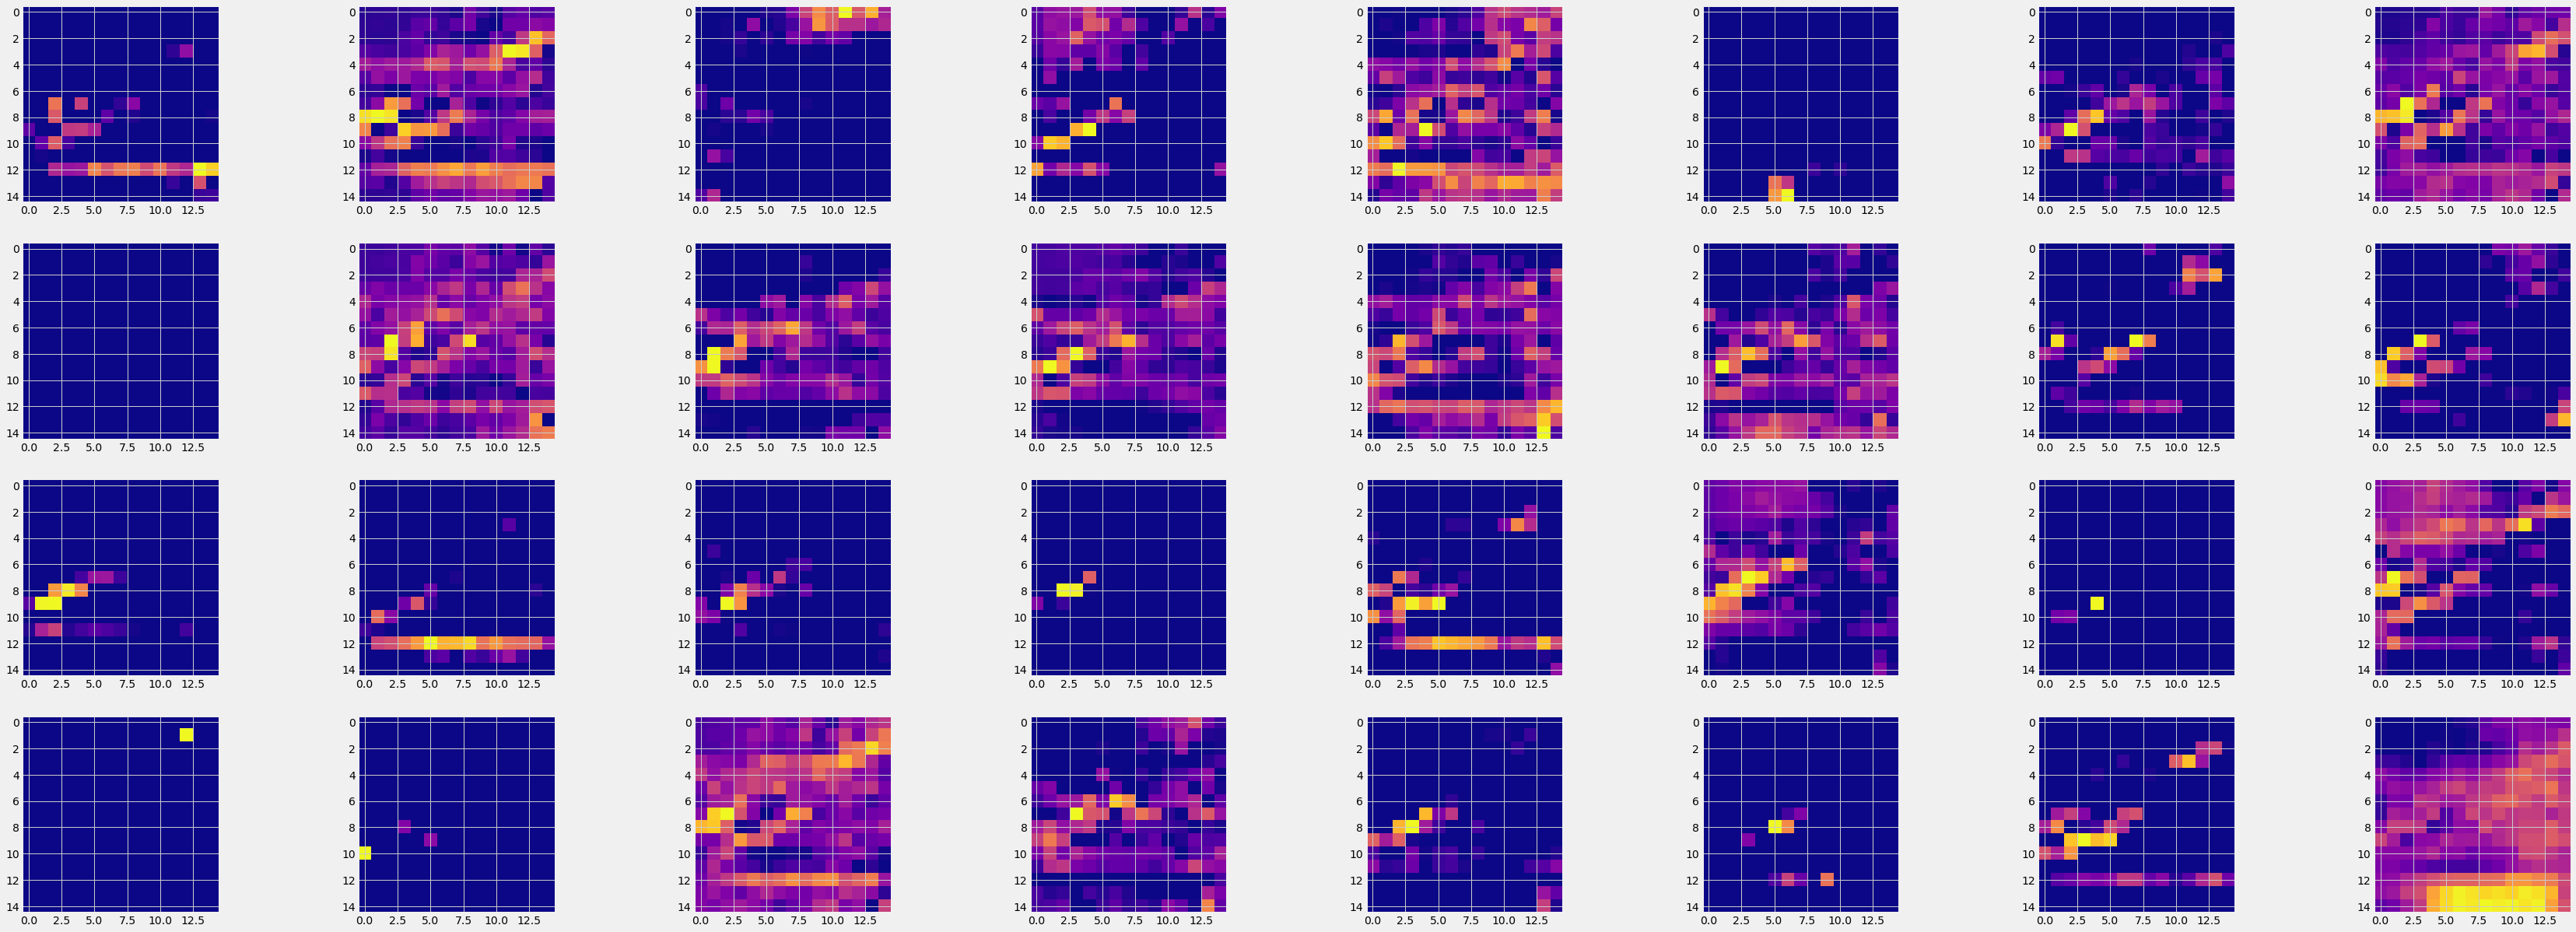

In [308]:
display_activation(activations, 8, 4, 1)

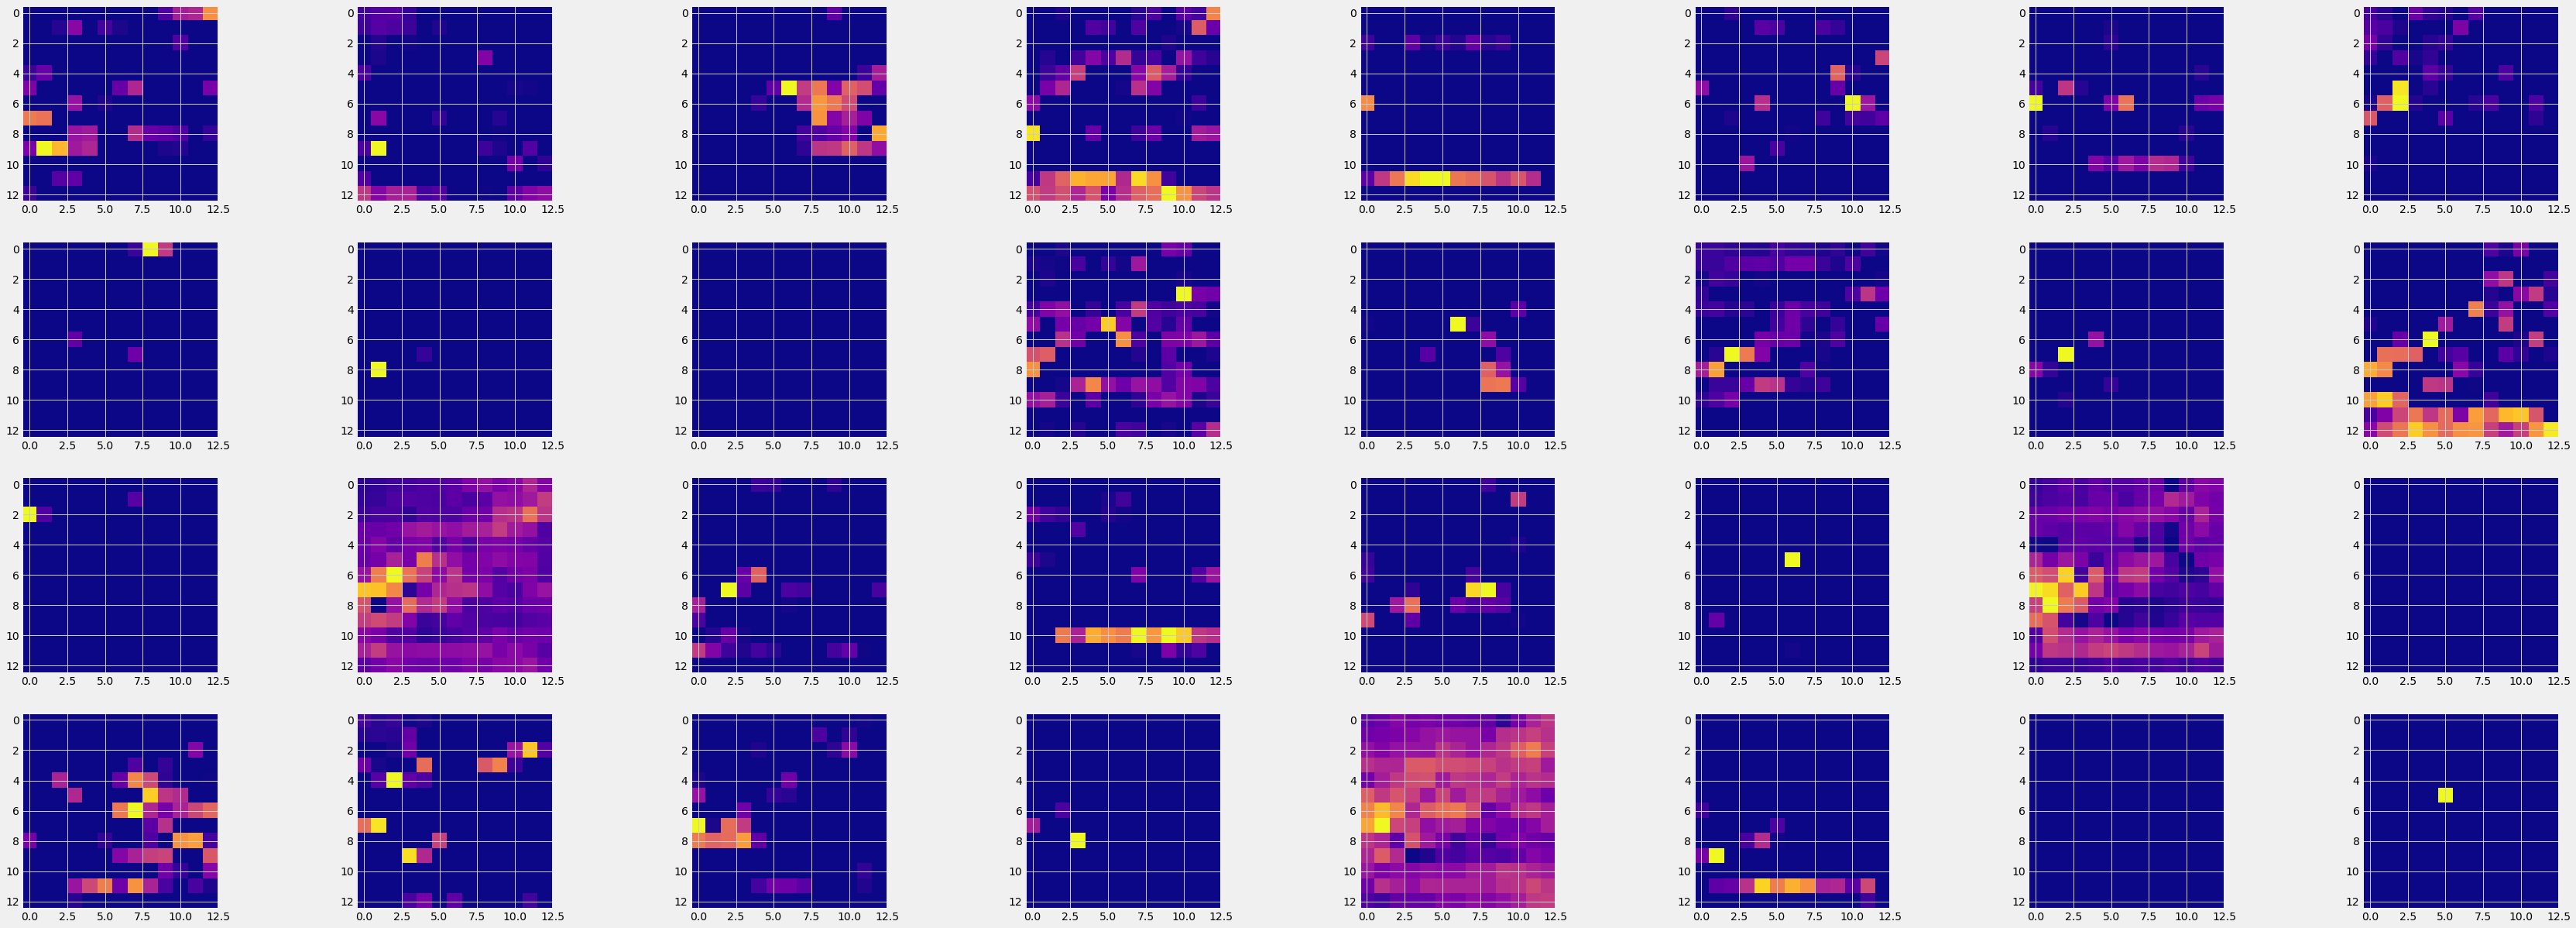

In [309]:
display_activation(activations, 8, 4, 2)

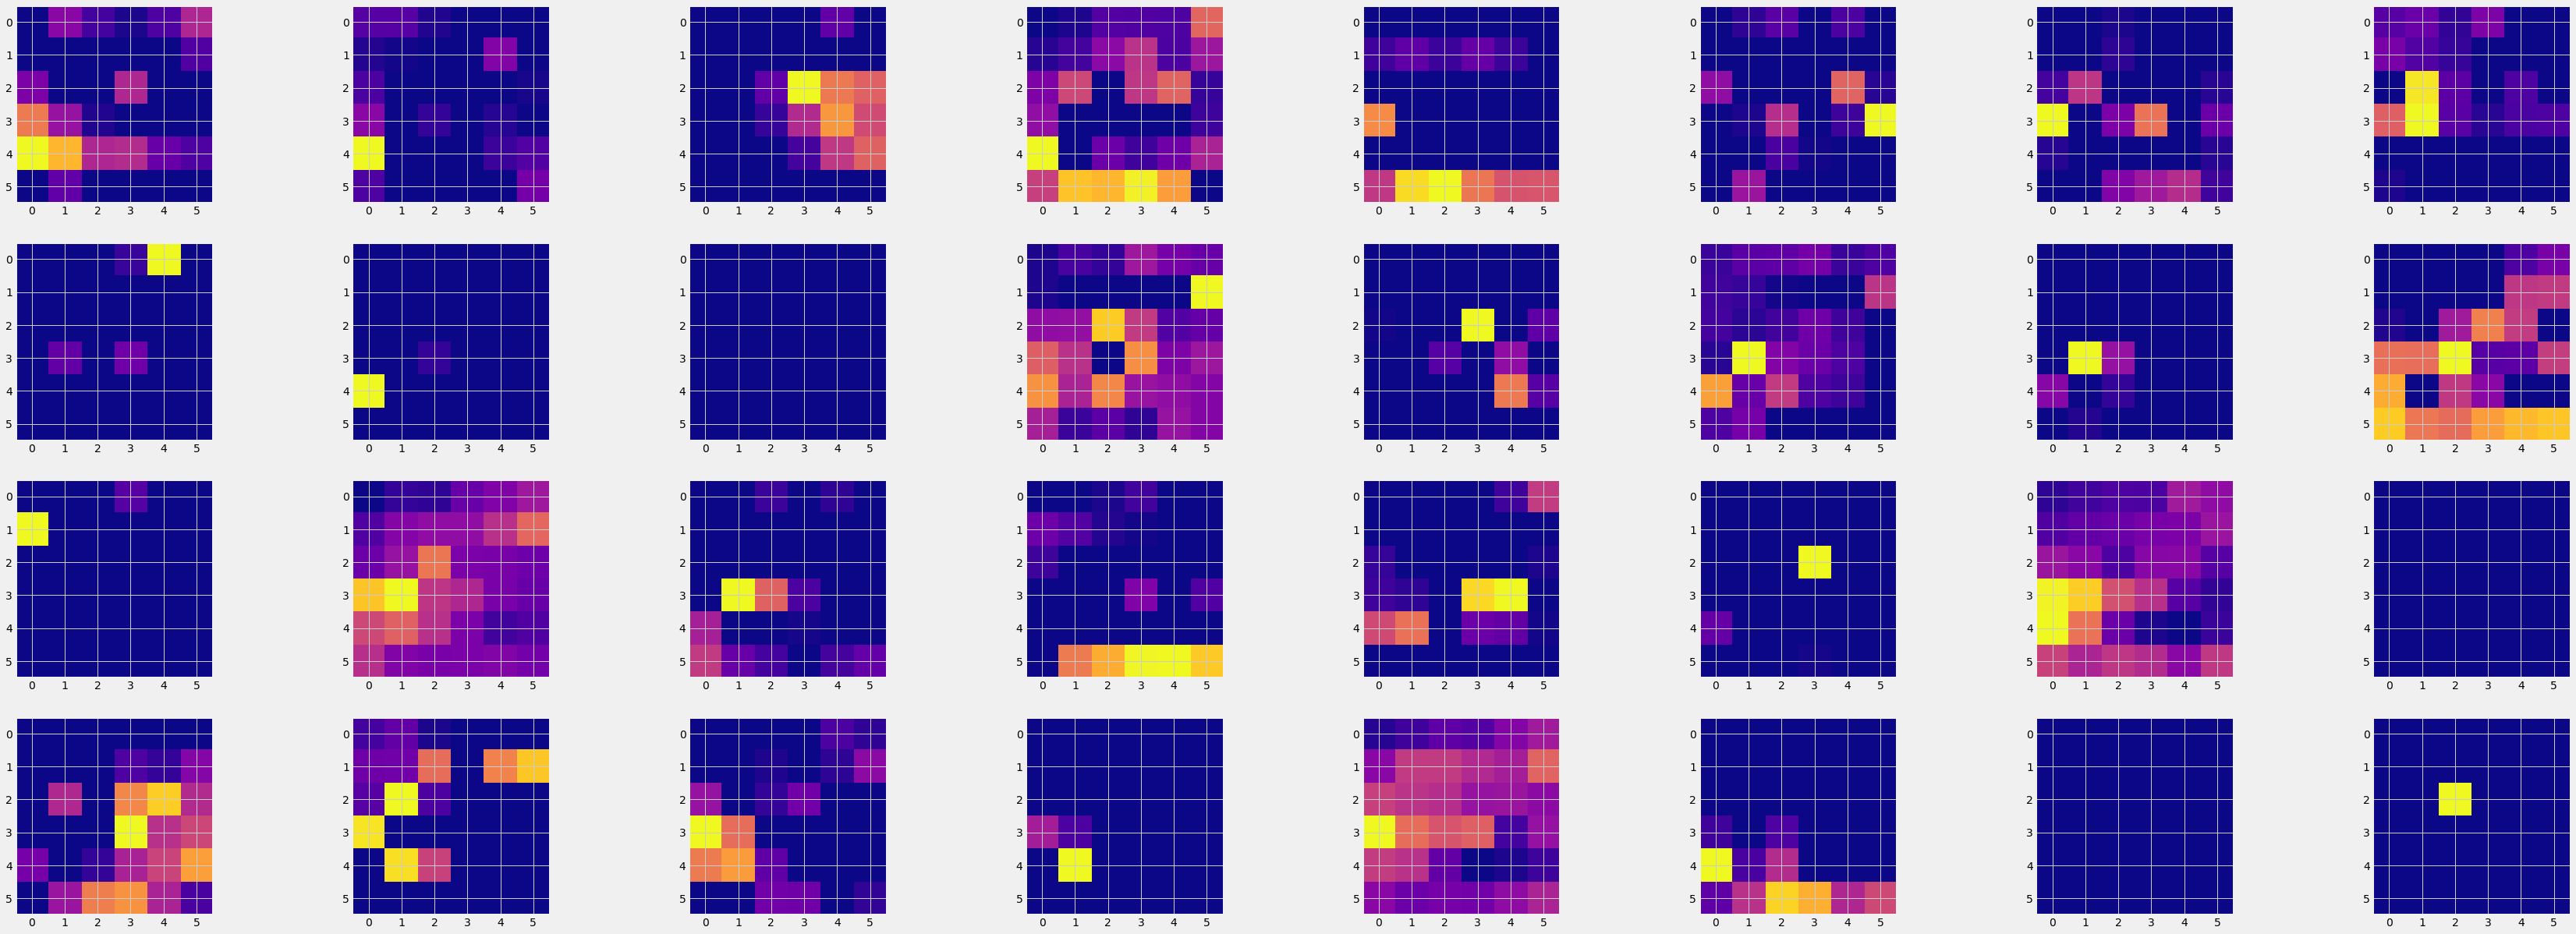

In [310]:
display_activation(activations, 8, 4, 3)

**Conclusion :**

Les nouvelles couches ne semblent pas apportées grand chose au modèle. Testons en supprimant le premier pooling.

## TEST 4 - On rajoute une nouvelle Convolution

In [311]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model4.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(3, activation='softmax'))

model4.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_111 (Dense)            (None, 3)                 37635     
Total params: 57,027
Trainable params: 57,027
Non-trainable params: 0
_________________________________________________________________


In [312]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training = model4.fit_generator(train_generator, epochs=NUM_EPOCHS, validation_data=test_generator)

Epoch 1/10
19/19 [==============================] - 2s 125ms/step - loss: 40.2146 - accuracy: 0.4225 - val_loss: 2.9834 - val_accuracy: 0.4667
Epoch 2/10
19/19 [==============================] - 2s 99ms/step - loss: 1.1259 - accuracy: 0.6942 - val_loss: 0.9334 - val_accuracy: 0.6833
Epoch 3/10
19/19 [==============================] - 2s 99ms/step - loss: 0.5506 - accuracy: 0.7725 - val_loss: 0.7122 - val_accuracy: 0.7667
Epoch 4/10
19/19 [==============================] - 2s 98ms/step - loss: 0.3539 - accuracy: 0.8650 - val_loss: 0.6118 - val_accuracy: 0.7833
Epoch 5/10
19/19 [==============================] - 2s 101ms/step - loss: 0.2387 - accuracy: 0.9083 - val_loss: 0.6186 - val_accuracy: 0.7833
Epoch 6/10
19/19 [==============================] - 2s 99ms/step - loss: 0.1608 - accuracy: 0.9467 - val_loss: 0.6225 - val_accuracy: 0.8167
Epoch 7/10
19/19 [==============================] - 2s 99ms/step - loss: 0.1011 - accuracy: 0.9667 - val_loss: 0.5983 - val_accuracy: 0.8333
Epoch 8/10

In [313]:
model4.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

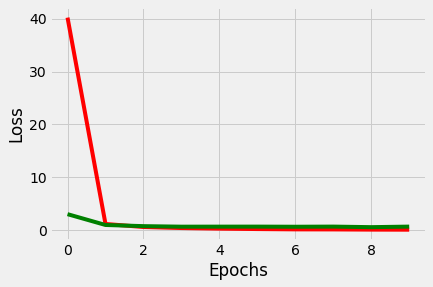

In [314]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [315]:
layer_outputs = [layer.output for layer in model4.layers]

test_image = "./DATAS/CURATED/test/crocodile/0097.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model4.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

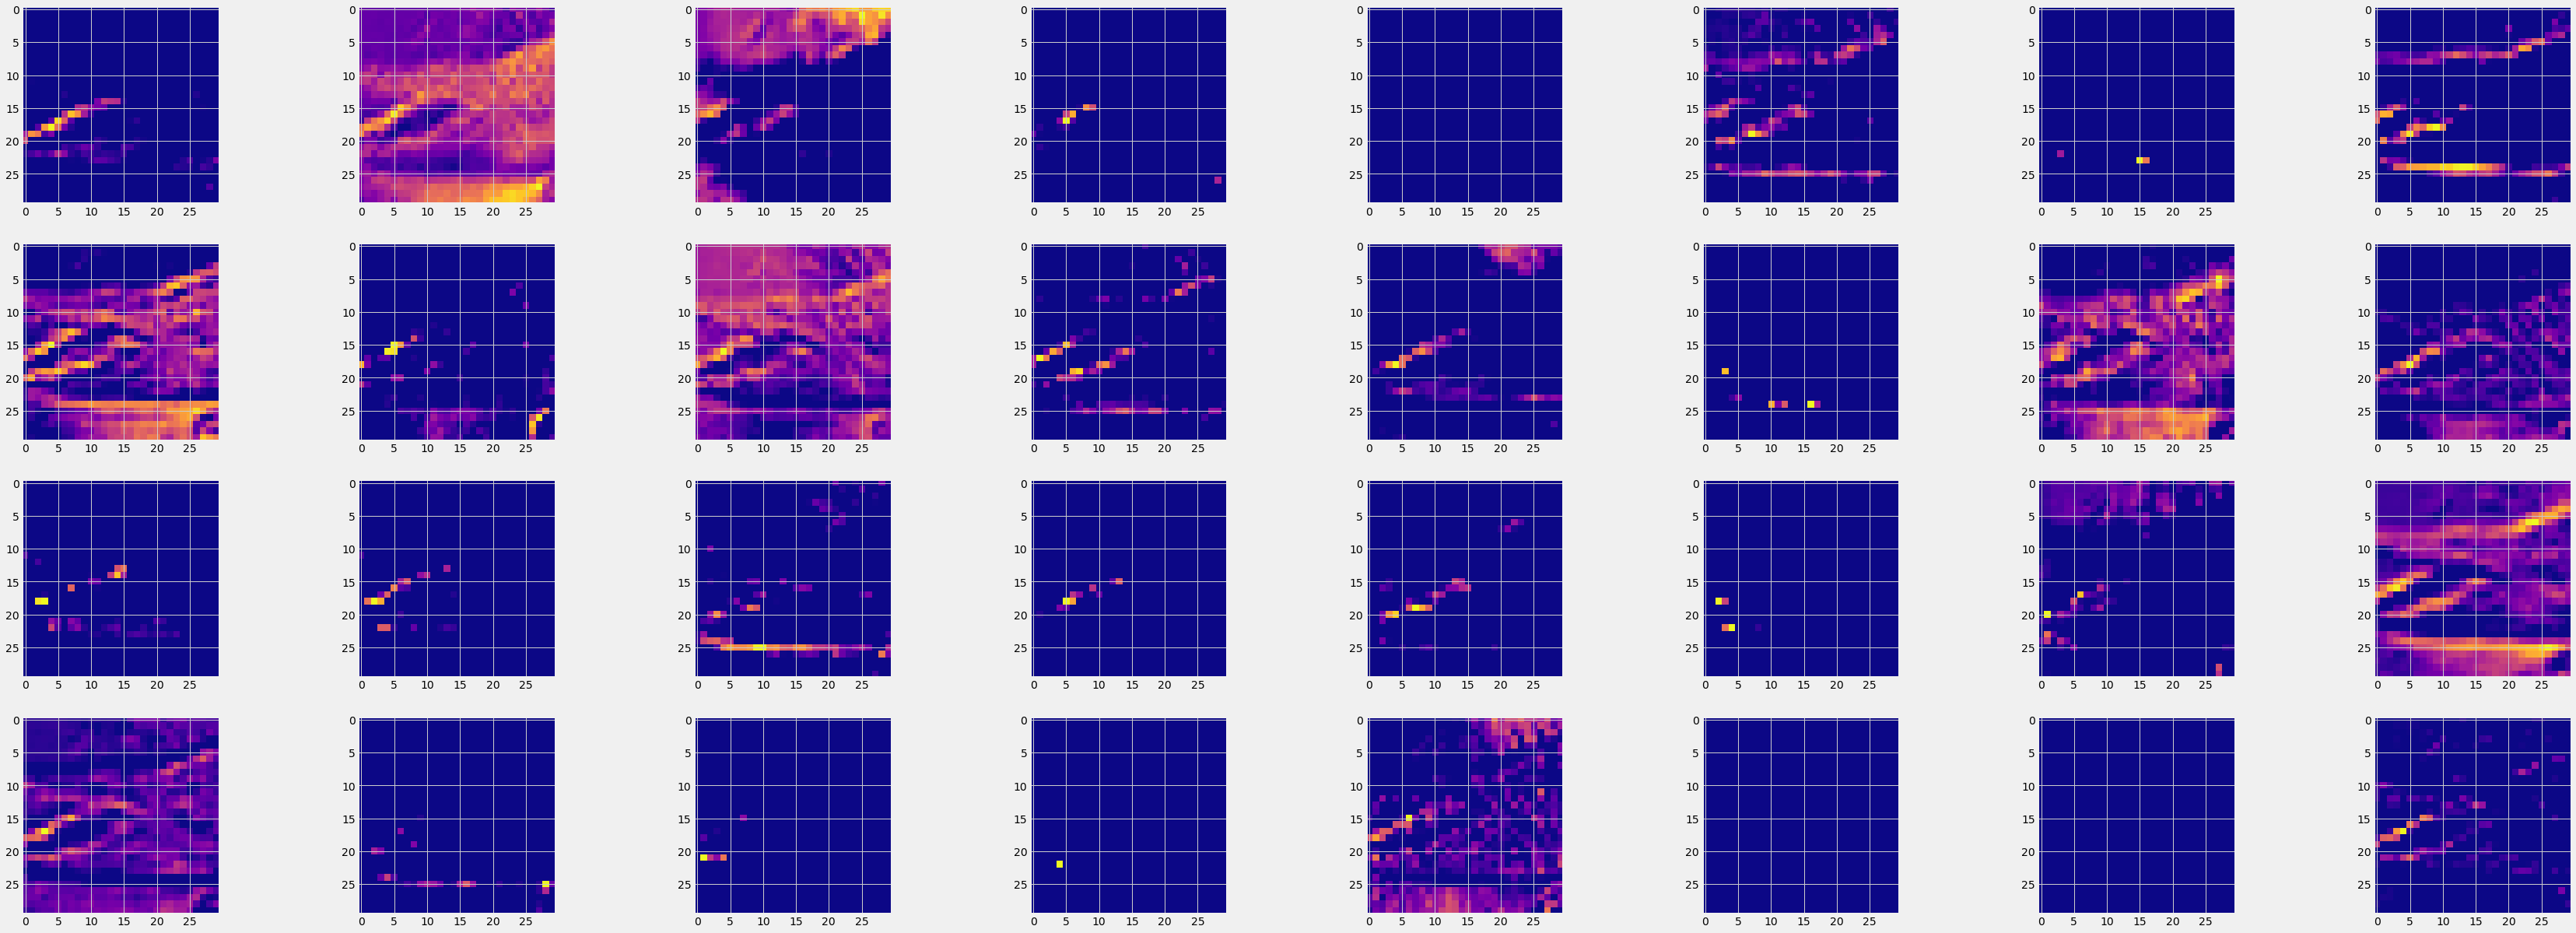

In [316]:
display_activation(activations, 8, 4, 0)

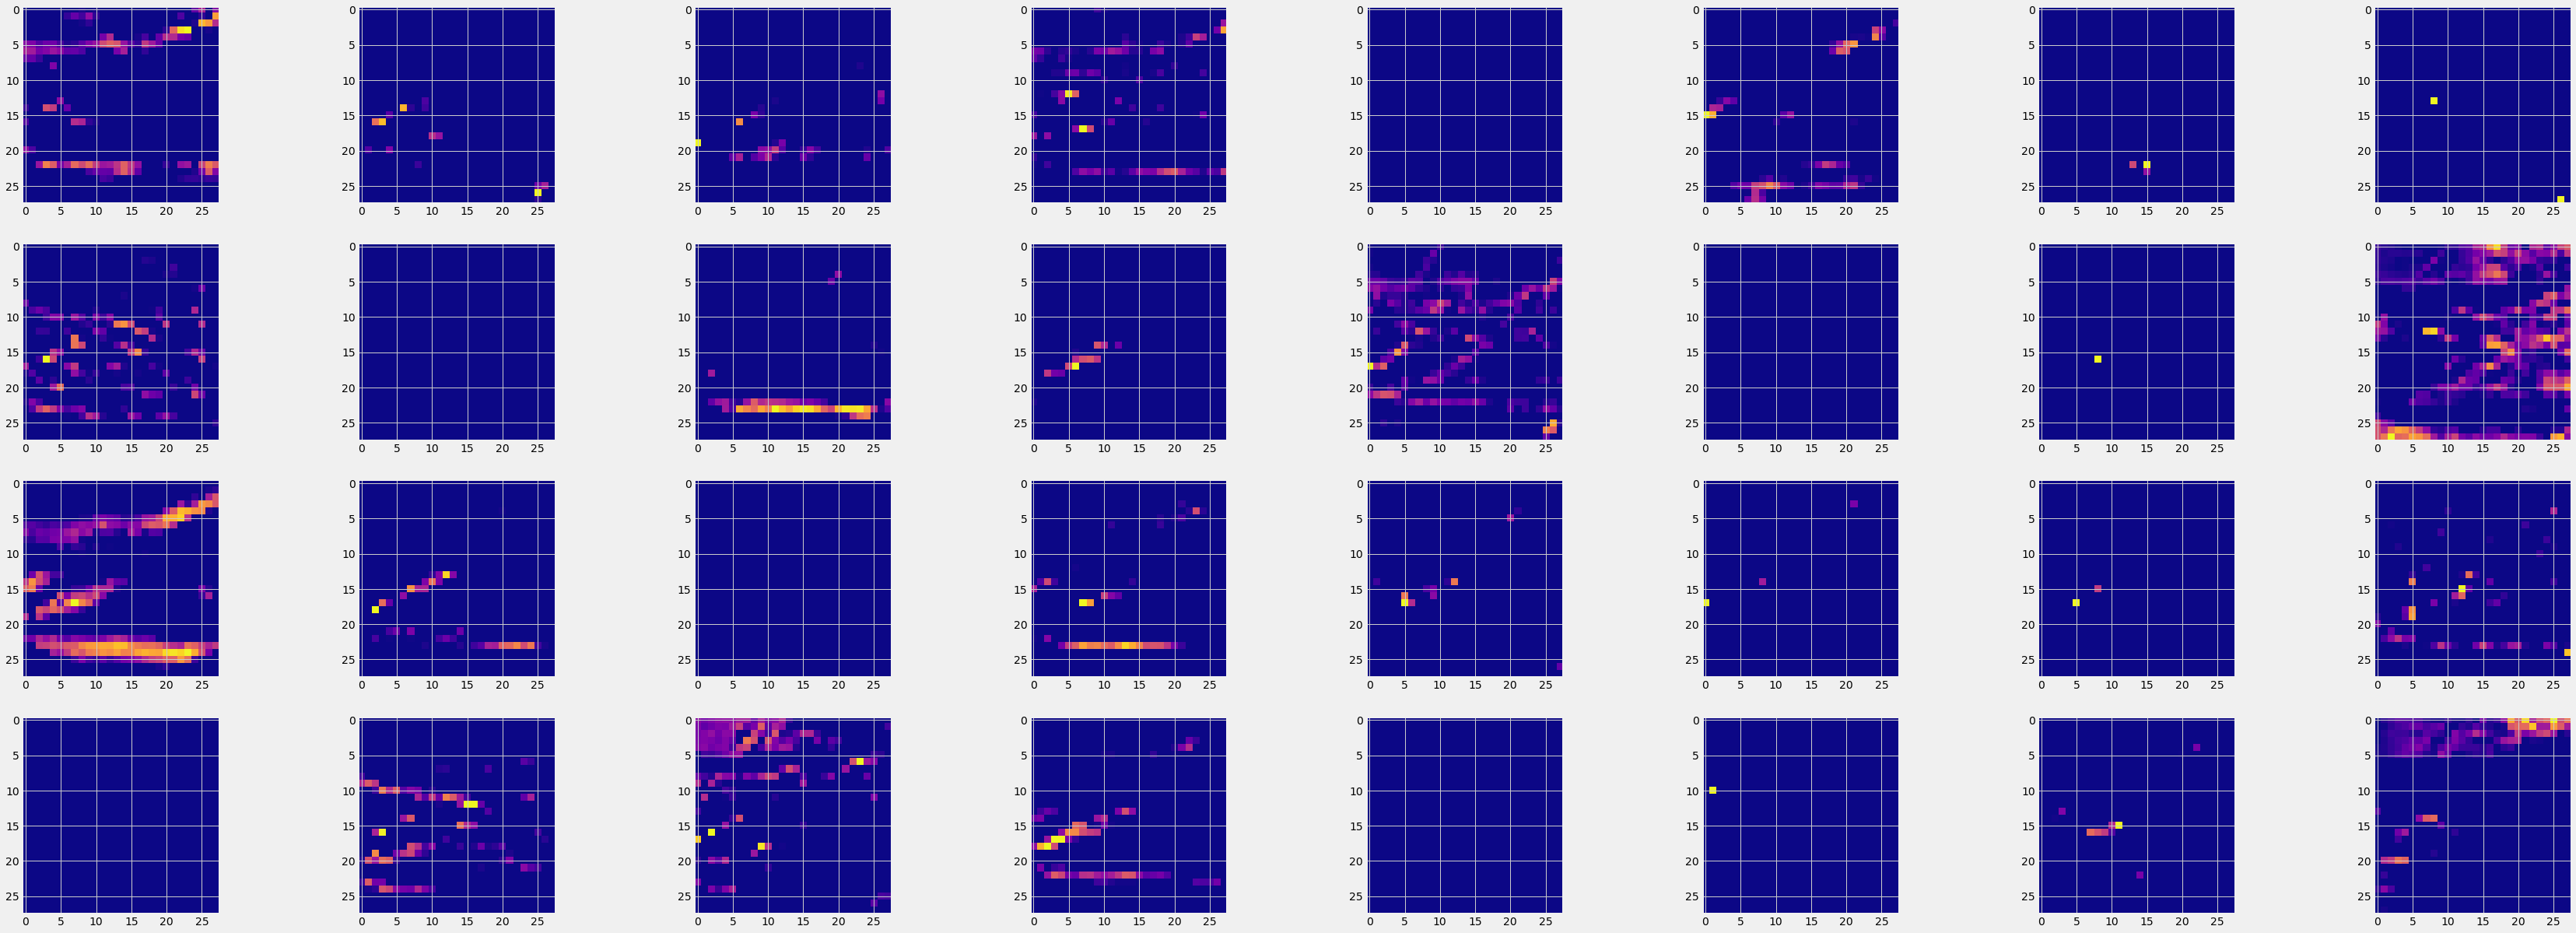

In [317]:
display_activation(activations, 8, 4, 1)

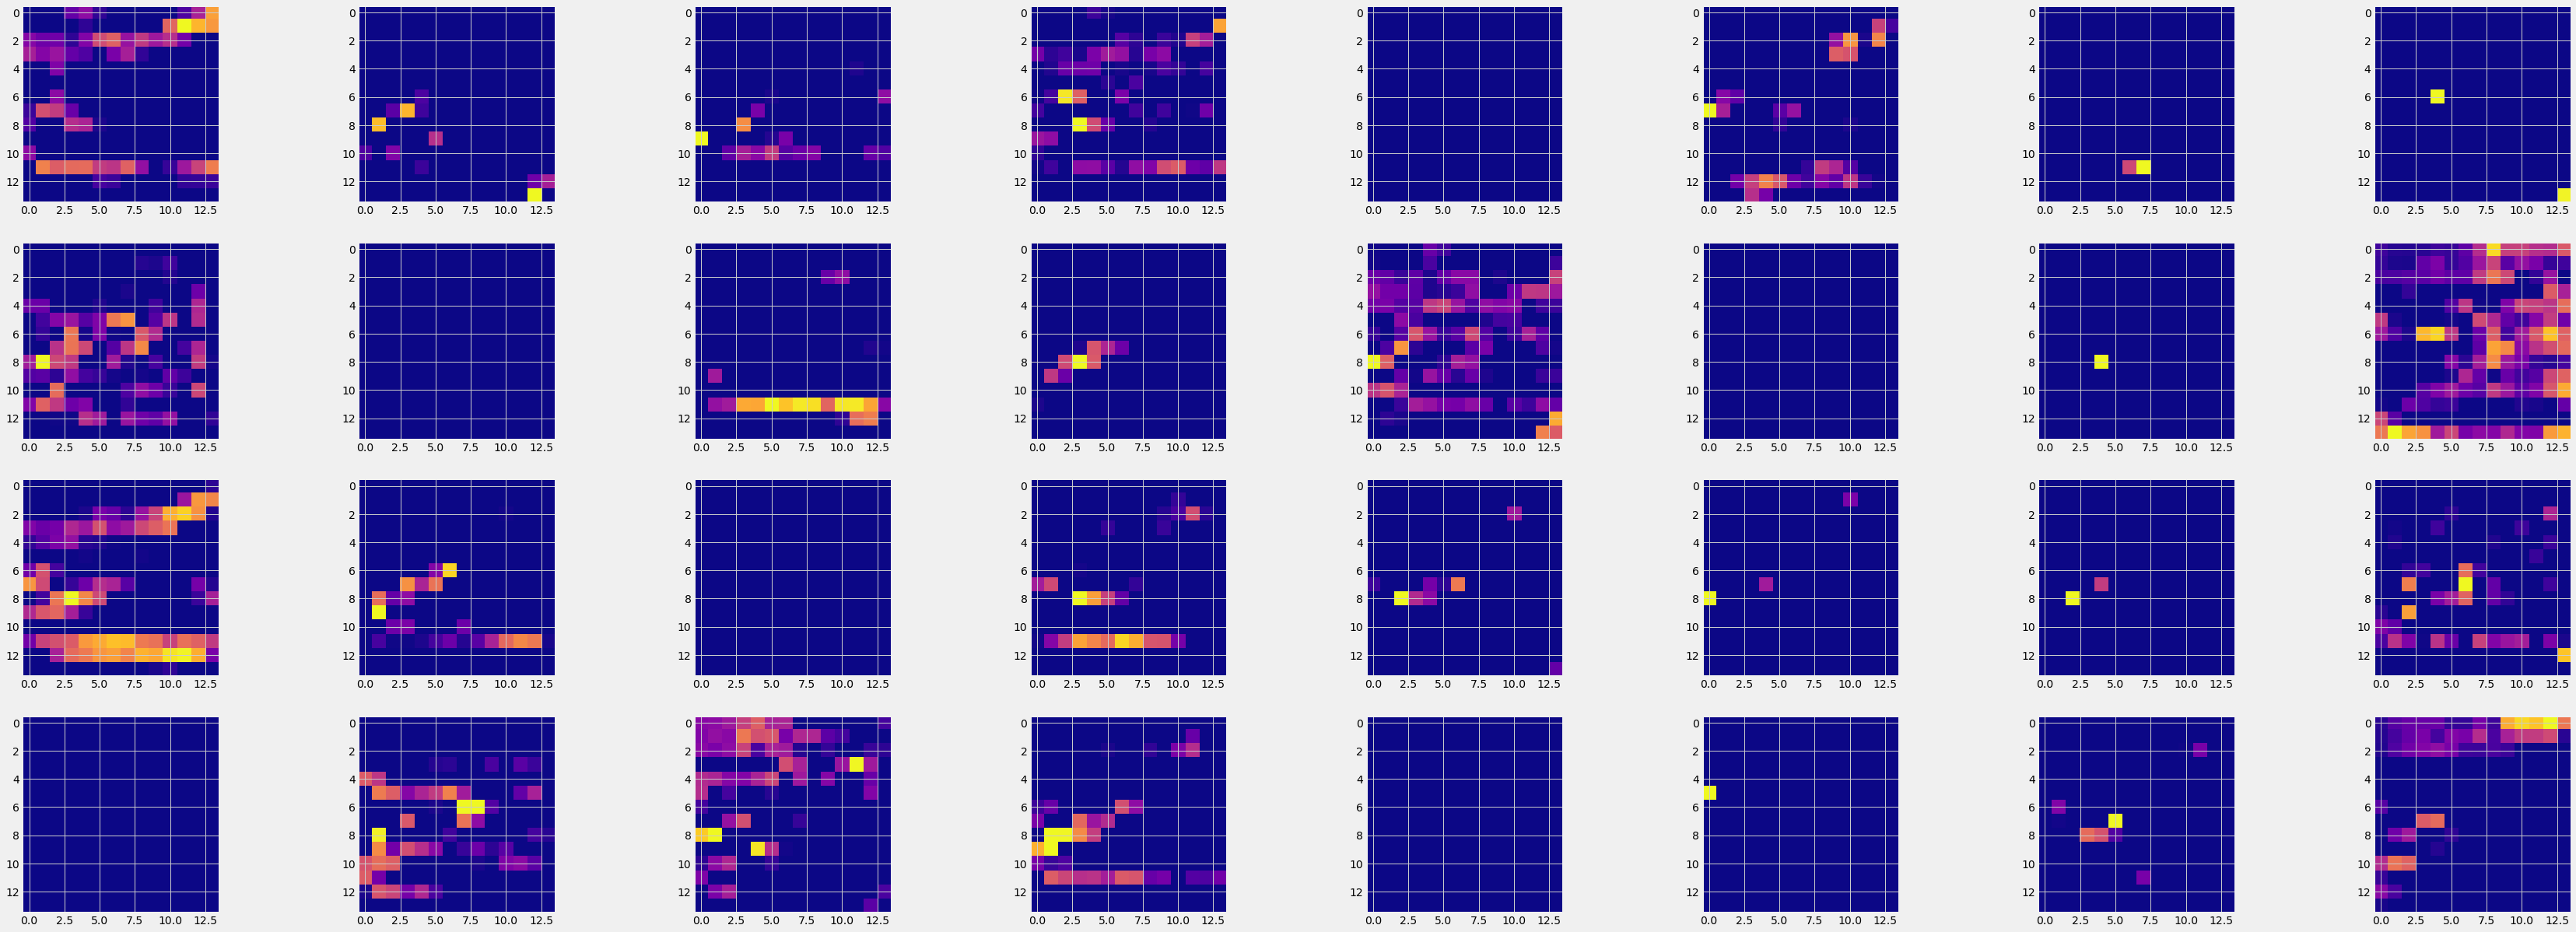

In [318]:
display_activation(activations, 8, 4, 2)

**Conclusion :**

La seconde convolution conserve une partie des contours du crocodile, mais difficile d'affirmer qu'elle apporte qqch de plus au modèle.